In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
os.environ['AUTO_DIR'] = '/home/contreras/Documents/Auto4Servers/compute2/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
### Add path to functions
sys.path.insert(1, './functions')
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto

In [2]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [3]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [4]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [5]:
def saving_pdf_figure(fig,fig_name,md_dir,raster=False):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    if raster:
        if raster>1:
            rast=raster
        else:
            rast=300
        ax.savefig(fig_name+'.png',dpi=rast)
        fig.savefig(pdffig, format="pdf",dpi=rast)
    else:
        ax.savefig(fig_name+'.png')
        fig.savefig(pdffig, format="pdf")

    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [6]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [7]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

#########################################################
#### Function to adjust Jmat dimensions for eigenvalue calculation..
#########################################################
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])

    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat



In [8]:
### Importing the thesis format for figures
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

In [9]:
## Loading neuron model (file in the cfg folder)
model_name_p0='MTM_W_sPNaS_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name_p0+'.json',strIapp=strIapp)
x_neuron=copy(neuron_snap)
### We will choose for the analysis this model..
model_name=model_name_p0

### Importing data created in Bifurcation_Graph_Ko.ipynb

In [10]:
### Importing data that created the bif graph
dir_sims='./Data/'
name='Bifurcation_Graph_Iapp_Ko_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_Bif_graph_data=pickle.load(f)

v_s_par=d_Bif_graph_data['Bif_parameters']
v_s_var=d_Bif_graph_data['state_pars']
m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
m_res_par_HF0=d_Bif_graph_data['Hopf_par']
m_res_statev_HF=d_Bif_graph_data['Hopf_var']


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


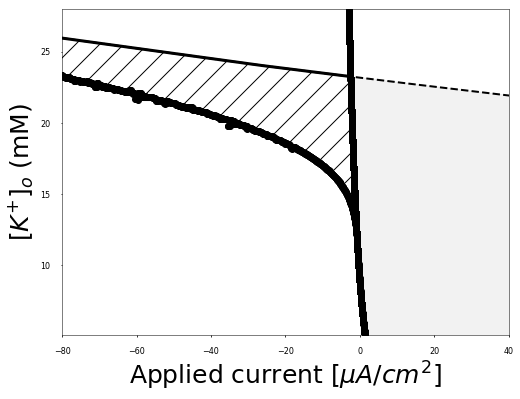

In [11]:
from scipy.interpolate import interp1d
size_axis_font=25
plt.close("all")

fig01 = plt.figure(facecolor="1",figsize=(8,6))
axx = fig01.add_subplot(111)
xlim=[-80,40]
ylim=[5.1,28]
axx.set_xlim(xlim)
axx.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axx.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axx.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axx.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axx.set_ylabel('$[K^{+}]_o $ (mM)',fontsize=size_axis_font)
axx.set_xlabel('Applied current $[\mu A/cm^2]$',fontsize=size_axis_font)
axx.tick_params(axis='y', pad=10)
axx.tick_params(axis='x', pad=10)
plt.show()




# Escape rate

SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.1618788927600001_K_o_13.0_sigma_0.5 exists!
0%
escape rate for line integral 270.8623708440032
mean in plot 376.0302665621898
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.05148487374_K_o_13.0_sigma_0.5 exists!
0%
20%
40%
60%
80%
escape rate for line integral 68.45587138555199
mean in plot 99.36354670906415


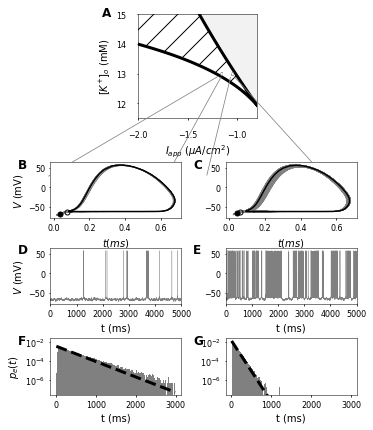

<Figure size 410.4x360 with 0 Axes>

In [17]:
from sympy import S, symbols, lambdify
### Properties of 
###############################################################################################################
##### Figure.. ISI dist and escape rate..
###############################################################################################################

##############################################
K_o=13.0
I_app=-10
### Finding bistable region boundaries for particular Ko
lb=m_res_par_lc_KoIapp[s_x][np.argmin(np.abs(m_res_par_lc_KoIapp[s_y]-K_o))]
ub=m_res_par_sn_KoIapp[s_x][np.argmin(np.abs(m_res_par_sn_KoIapp[s_y]-K_o))]

## Applied currents in the subthreshold, bistable, and spiking regions.
if (ub-lb)/5>1*10**-3:
    t_I_app_specf=[lb+(ub-lb)/5,lb+2*(ub-lb)/5,lb+3*(ub-lb)/5,lb+4*(ub-lb)/5]
#     t_I_app_specf=[lb+(ub-lb)/10,lb+2*(ub-lb)/10,lb+3*(ub-lb)/10,lb+4*(ub-lb)/10,lb+5*(ub-lb)/10,lb+6*(ub-lb)/10,lb+7*(ub-lb)/10,lb+8*(ub-lb)/10,lb+9*(ub-lb)/10]
else:
    t_I_app_specf=[lb+(ub-lb)/2]


### Noise only in the voltage dimension
sii=0.5#\muA
sigma_v=[sii,0,0,0] 
num_neurons=500

##############################################################################################################
##### Figure.. Axes..

plt.close("all")
f1 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.4))
axpl = plt.subplot2grid((80,80), (0, 22), colspan=30,rowspan=22)

ax0l = plt.subplot2grid((80,80), (31, 0), colspan=33,rowspan=12)
ax1l = plt.subplot2grid((80,80), (49, 0), colspan=33,rowspan=12)
ax2l = plt.subplot2grid((80,80), (68, 0), colspan=33,rowspan=12)

ax0r = plt.subplot2grid((80,80), (31, 44), colspan=33,rowspan=12,sharey=ax0l,sharex=ax0l)
ax1r = plt.subplot2grid((80,80), (49, 44), colspan=33,rowspan=12,sharex=ax1l,sharey=ax1l)
ax2r = plt.subplot2grid((80,80), (68, 44), colspan=33,rowspan=12,sharex=ax2l,sharey=ax2l)


##############################################################################################################
##### Define array of axes.. 
ax0=[ax0l,ax0r]
ax1=[ax1l,ax1r]
ax2=[ax2l,ax2r]
##############################################################################################################
##### principal axes with the bif graph.. Axes..

axpl.set_xlim([-2,-0.8])
axpl.set_ylim([11.5,15])
### Classic bif graphs... instead of scattered version
s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axpl.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],color=[0,0,0])
axpl.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axpl.set_ylabel('$[K^{+}]_o$ (mM)')
axpl.set_xlabel('$I_{app}$ $(\mu A/cm^2)$')
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)


##############################################################################################################
##### Extract data from simulation..
i_api_ii=4
I_iapi_vvv=np.array([0,3])
I_app_vv=np.array(t_I_app_specf)
ii_ax=0
for i_api_ii in I_iapi_vvv:
    I_app=t_I_app_specf[i_api_ii]
    bifpar={}
    bifpar[strIapp] = [str(t_I_app_specf[i_api_ii])+"* uA/cm2"]
    bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
    name='SIM_'+model_name+'_I_app_'+bifpar['I_app'][0][0:bifpar['I_app'][0].index('*')]+'_K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_sigma_'+str(sigma_v[0])

    if os.path.isfile('./Data/'+name+'.pkl'):
        print(name+' exists!')
        f=open('./Data/'+name+'.pkl', 'rb')
        d_save_sim=pickle.load(f)
        f.close()
        ####################### Extract attractor properties
        l0=d_save_sim['Dyn_Sys_Properties']['l0']
        limit_cycle=d_save_sim['Dyn_Sys_Properties']['limit_cycle']
        tau_lc=d_save_sim['Dyn_Sys_Properties']['tau_lc']
        saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
        stable=d_save_sim['Dyn_Sys_Properties']['stable']
        lam0=d_save_sim['Dyn_Sys_Properties']['lam0']
        lamfp=d_save_sim['Dyn_Sys_Properties']['lamfp']
        s_results=d_save_sim['s_results']
        v_results=d_save_sim['v_results']
        dlc=min(np.dot(l0,limit_cycle-saddle))
        yn=np.dot(l0,stable)
        ys_0=np.dot(l0,saddle)
        sig_eff=np.dot(sigma_v,l0)
        D=sig_eff**2
        
        if len(d_save_sim['Mult_spike_reals']['ISI_fp'])>0:
            ISI_fp_Traub=np.concatenate(d_save_sim['Mult_spike_reals']['ISI_fp'])
        else:
            ISI_fp_Traub=[]

        ##############################################################################################################
        ##### Plot voltage trace 

        idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
        idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
        idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n_K'][0]

        ax1[ii_ax].plot(v_results[idx_t,:],v_results[idx_v,:],color='grey',linewidth=matplotlib.rcParams['lines.linewidth']*0.2,rasterized=True)
        ax1[ii_ax].set_xlabel(s_results[idx_t]+' (ms)')
        ax1[ii_ax].set_xlim(min(v_results[idx_t,:]),max(v_results[idx_t,:]))

        ### Showing where in the bif graph this is..
        zoomingBox(axpl, np.array([I_app_vv[i_api_ii]-0.01,I_app_vv[i_api_ii]+0.01,K_o-0.05,K_o+0.05]), ax0[ii_ax],color='grey',linewidth=matplotlib.rcParams['lines.linewidth']*0.5)

        ##############################################################################################################
        ##### Plot trajectory in phase plane
        ax0[ii_ax].plot(v_results[idx_nk,:],v_results[idx_v,:],linewidth=matplotlib.rcParams['lines.linewidth']*0.2,label='trajectory',color='grey',rasterized=True)
        ax0[ii_ax].plot(limit_cycle[idx_nk],limit_cycle[idx_v],label='stable limit cycle',color='black')
        ax0[ii_ax].plot(stable[idx_nk],stable[idx_v],'o',markersize=5,label='stable node',color='black')
        ax0[ii_ax].plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black')
        ax0[ii_ax].set_xlabel('$ t (ms) $')
        ax2[ii_ax].set_xlabel('$'+s_results[idx_nk]+'$')
        
        ##############################################################################################################
        ########## T_esc_theor from line integral
        ##############################################################################################################
        ### Loading the line integral in l0 that was calculated in (p_traub_to_GIF_potentials.py)
        dir_sims='./Data/'
        name='d_sample_of_det_potentials_'+model_name
        f=open(dir_sims+name+'.pkl', 'rb')
        d_POTs=pickle.load(f)
        f.close()
        ############################################################
        ### Finding the potential for this particular Iapp and Uy
        ############################################################
        v_Iappi_pots=[]
        v_Ko_pots=[]
        for d_pot_i in d_POTs:
            v_Ko_pots.append(d_pot_i['K_o'])
            v_Iappi_pots.append(d_pot_i['I_app'])

        pot_idx=np.array(range(len(v_Iappi_pots)))[v_Iappi_pots==I_app]
        if len(pot_idx)==1 and v_Ko_pots[pot_idx[0]]==K_o:
            pot_idx=pot_idx[0]
        elif len(pot_idx)>1:
            for ii_poti_idx in pot_idx:
                if v_Ko_pots[pii_poti_idx]==K_o:
                    pot_idx=ii_poti_idx

        yy_tot_t=d_POTs[pot_idx]['Dyn_Sys_Properties']['Det_Uy_in_l0']['yy_tot_t']
        Uy_tot_t=d_POTs[pot_idx]['Dyn_Sys_Properties']['Det_Uy_in_l0']['Uy_tot_t']
        ### shifting Uy such that U(0)=0
        Uy_tot_t=Uy_tot_t-Uy_tot_t[np.argmin(abs(yy_tot_t))]
        ############################################################
        ### Decreasing resolution, to optimiza running time
        ############################################################
        delta=0.001
        idxs_Vy_shrt=[]
        idxs_Vy_shrt.append(np.array(range(len(yy_tot_t)))[1:][np.diff(yy_tot_t)>delta])
        idxs_Vy_shrt.append(np.array(range(len(yy_tot_t)))[1:][(np.diff(yy_tot_t)<delta)*(np.diff(yy_tot_t)>0)][::10])
        idxs_Vy_shrt=np.sort(np.concatenate(idxs_Vy_shrt))
        Uy_temp=Uy_tot_t[idxs_Vy_shrt]
        yy_temp=yy_tot_t[idxs_Vy_shrt]

        def int1(y_a,y_b):
            idxs_Vy=np.array(range(len(yy_temp)))[(yy_temp>=y_a)*(yy_temp<=y_b)]
            v_y=yy_temp[idxs_Vy]
            return np.trapz((np.exp(Uy_temp[idxs_Vy]/D))*int2(v_y),x=v_y)

        def int2(v_yi):
            v_int1=[]
            count=0
            for yi in v_yi:
                if int((count/len(v_yi))*100)==(count/len(v_yi))*100:
                    print(str(int((count/len(v_yi))*100))+'%')

                idxs_Vy=np.array(range(len(yy_temp)))[(yy_temp>=-100.0)*(yy_temp<=yi)]
                v_y=yy_temp[idxs_Vy]
                v_int1.append(np.trapz(np.exp(-Uy_temp[idxs_Vy]/D),x=v_y))
                count+=1

            return v_int1

        T_esc_theor_pure=(1.0/D)*int1(yn[0]-ys_0[0],float('%.4g' % dlc))
        ##############################################################################################################
        ##### Plot probability distribution of time spent in fp
        a0,b0,c0=ax2[ii_ax].hist(ISI_fp_Traub, bins=range(10,3000,10),density=True,histtype='bar',color='grey',rasterized=True)

        print('escape rate for line integral '+str(T_esc_theor_pure))
        print('mean in plot '+str(np.mean(ISI_fp_Traub)))

        par_exp = {"taue": str(T_esc_theor_pure)}
        exppdf = S("exp(-t/taue)/taue")
        exp_foo = lambdify("t",exppdf.subs(par_exp))
        theor_dist=exp_foo(b0)
        ax2[ii_ax].set_xlabel('t (ms)')
        ax2[ii_ax].semilogy(b0,theor_dist,'--',label='Theory',color='black',linewidth=3.0)
                


            
            
    else:
        print('File '+name+'...Doesnt exist :(:(')
        
    ii_ax+=1


ax1[0].set_ylabel('$V$ (mV)')
ax0[0].set_ylabel('$V$ (mV)')
ax2[0].set_ylabel(r'$p_e(t)$')

############################################
### Labels
############################################
v_ax=[axpl,ax0l,ax0r,ax1l,ax1r,ax2l,ax2r]
import string
ni=0
for n, axs in enumerate(v_ax):
    if n==0:
        axs.text(-0.3, 0.98, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')
    else:
        axs.text(-0.25, 0.9, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=matplotlib.rcParams["font.size"],weight='bold')




# print(tau_ee)
fig_name='traces_4_different_dsn_wPstable_node_t_plusTheory_'+model_name

md_dir={}
md_dir['Title']='traces with different dlc and dsn in bistable region with distribution of PISI(t)'+model_name+' for sigmav='+str(sigma_v)+' Ko='+str(K_o)+' and applied currents Iapp='+''.join(['_'+str(I_app_vv[i_api_ii]) for i_api_ii in I_iapi_vvv])
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(f1,'./figs/'+fig_name,md_dir,raster=300)
# plt.show()

In [18]:
md_dir

{'Title': 'traces with different dlc and dsn in bistable region with distribution of PISI(t)MTM_W_sPNaS_snapshot_p0 for sigmav=[0.5, 0, 0, 0] Ko=13.0 and applied currents Iapp=_-1.1618788927600001_-1.05148487374',
 'Author': 'Susana Contreras',
 'Subject': 'stochastic bursting',
 'Keywords': 'Bistability, concentration dynamics, spiking statistics'}